# SlashGPT Architecture

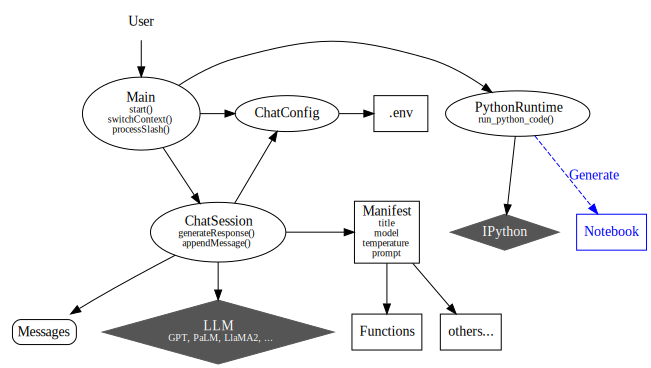

In [145]:
from graphviz import Source
from IPython.display import display

diagram = """
digraph {
    Main [label=<Main<br/><font point-size='10'>start()<br/>switchContext()<br/>processSlash()</font>>];
    ChatConfig;
    ChatSession [label=<ChatSession<br/><font point-size='10'>generateResponse()<br/>appendMessage()</font>>];
    PythonRuntime [label=<PythonRuntime<br/><font point-size='10'>run_python_code()</font>>];
    
    User [shape=plaintext]
    
    node [shape=box]
    Manifest [label=<Manifest<br/><font point-size='10'>title<br/>model<br/>temperature<br/>prompt</font>>];
    Env [label=".env"]
    Functions;
    Others [label="others..."];
    Notebook [color="blue" fontcolor="blue"]

    Messages [
        shape=plaintext
        label=<<table border='1' cellborder='0' style='rounded'><tr><td>Messages</td></tr></table>>
    ]

    node [shape=diamond, style=filled, color="#555555" fontcolor="white"]
    IPython 
    LLM [label=<LLM<br/><font point-size='10'>GPT, PaLM, LlaMA2, ...</font>>];

    ChatConfig -> Env
    User -> Main
    Main -> ChatSession;
    ChatSession, Main -> ChatConfig;
    ChatSession -> LLM;
    ChatSession -> Manifest;
    Main -> PythonRuntime
    PythonRuntime -> IPython
    PythonRuntime -> Notebook [style=dashed, color=blue, label="Generate" fontcolor="blue"]
    Manifest -> { Functions, Others };
    ChatSession -> Messages
    { rank=same Main, PythonRuntime, ChatConfig, Env }
    { rank=same ChatSession Manifest }
    { rank=same Functions Others }
}
"""

graph = Source(diagram)
display(graph)

# Components

### Main

Main object is the main application object, which has the runloop. It creates a ChatConfig object first, then create multiple ChatSession objects sequentially during the lifetime of the application.

### ChatConfig

ChatConfig object is a singletone object, which keeps various global variables, such as OpenAI key and "verbose mode" flag, across multiple chat sessions. It calls its SwitchContext() function to terminate the current chat session and start another.

### ChatSession

ChatSession object maintains the list of messages between the user and the agent, along with other properties of the session, such as the name of LLM model, temperature and system prompt. A new ChatSession object is initialized with a manifest file, which defines the behavior of the agent. 

### PythonRunTime

PythonRuntime is a library which acts as a Python runtime engine, which executes generated code by LLMs. It uses IPython as the default runtime, but can use CodeBox as an alternative. It generages a Jupyter notebook file for each "notebook" session (= a chat session which executes generated Python code). 

# Architecture

This architecture was chosen so that developers can build variety of AI agents quickly without writing any code, or even programatically generate new agents. All the behaviors of each AI agent will be fully described in its metafile, which is just a JSON file with a set of properties. 

For example, the JSON file below defines the "jupyter" agent, which mimics the bahavior of ChatGPT's code interpreter.

```json
{
  "title": "Jupyter Notebook with GPT3.5",
  "bot": "Jupyter",
  "source": "snakajima",
  "temperature": "0.0",
  "functions": "./resources/jupyter.json",
  "model": "gpt-3.5-turbo-16k-0613",
  "sampe": "Graph 4 year stock price of apple and tesla using yfinance",
  "notebook": true,
  "prompt": [
    "You are a data scientist who writes Python code to analyze data.",
    "When you write Python code, call 'run_python_code' function.",
    "When you see errors in your code, fix it and rerun it up to three times",
    "Current time is {now}."
  ]
}
```
The function propety specifies the location of the definition of available functions (for GPT's "function calls"), which has only one function, "run_python_code".
```json
[
  {
    "name": "run_python_code",
    "description": "Run a python code on a notebook",
    "parameters": {
      "type": "object",
      "properties": {
        "code": {
          "type": "array",
          "items": {
            "type": "string"
          },
          "description": "Python code to run"
        },
        "query": {
          "type": "string",
          "description": "Query from the user as-is"
        }
      },
      "required": ["code", "query"]
    }
  }
]
```
When the user enters a query like "Graph 4 year stock price of apple and tesla using yfinance", GPT generates an Python code and indicates that it wants to call "run_python_code" method (via GPT's "function call" feature).